In [1]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import clone
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import plotly.graph_objects as go
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
import warnings

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')
SEED = 27

In [2]:
dataset = pd.read_csv('/kaggle/input/lonn-data/kode24s_lonnstall_2023.csv')
dataset = dataset.dropna(subset=['lønn'])

In [3]:
dataset

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
0,21-25,2.0,5.0,"in-house, privat sektor",Oslo,sikkerhet,100 - 500,350000.0,Ja,Ja
1,26-30,0.0,1.0,"in-house, privat sektor",Innlandet,fullstack,100 - 500,350000.0,Nei,Nei
2,31-35,3.0,14.0,"in-house, privat sektor",Viken,ingen av disse,100 - 500,350000.0,Nei,Nei
3,26-30,NaN,3.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,350000.0,Ja,Nei
4,31-35,4.0,0.0,"in-house, privat sektor",Viken,fullstack,under 10,350000.0,Nei,Nei
...,...,...,...,...,...,...,...,...,...,...
2301,46-50,3.0,25.0,frilans / selvstendig næringsdrivende,Viken,arkitektur,under 10,2500000.0,Nei,Ja
2302,41-45,5.0,17.0,"in-house, privat sektor",Oslo,embedded/IOT/maskinvare,1.000 - 10.000,2950000.0,Ja,Ja
2303,41-45,5.0,20.0,frilans / selvstendig næringsdrivende,Oslo,backend,under 10,2950000.0,Nei,Ja
2304,31-35,5.0,9.0,frilans / selvstendig næringsdrivende,Rogaland,fullstack,over 10.000,3000000.0,Nei,Ja


# Topp 10 best betalte

In [4]:
dataset.sort_values(by='lønn', ascending=False).head(10)

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
2305,46-50,5.0,22.0,"in-house, privat sektor",Oslo,ledelse/administrativt,100 - 500,3500000.0,Ja,Ja
2304,31-35,5.0,9.0,frilans / selvstendig næringsdrivende,Rogaland,fullstack,over 10.000,3000000.0,Nei,Ja
2303,41-45,5.0,20.0,frilans / selvstendig næringsdrivende,Oslo,backend,under 10,2950000.0,Nei,Ja
2302,41-45,5.0,17.0,"in-house, privat sektor",Oslo,embedded/IOT/maskinvare,1.000 - 10.000,2950000.0,Ja,Ja
2301,46-50,3.0,25.0,frilans / selvstendig næringsdrivende,Viken,arkitektur,under 10,2500000.0,Nei,Ja
2300,36-40,5.0,12.0,"in-house, privat sektor",Oslo,ledelse/administrativt,over 10.000,2500000.0,Ja,Ja
2299,26-30,5.0,5.0,frilans / selvstendig næringsdrivende,utlandet,sikkerhet,50 - 100,2500000.0,Ja,Ja
2298,51-55,3.0,29.0,konsulent,Oslo,fullstack,10 - 50,2500000.0,Ja,Ja
2297,31-35,3.0,10.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,2330000.0,Nei,Ja
2295,26-30,3.0,5.0,frilans / selvstendig næringsdrivende,Oslo,fullstack,under 10,2300000.0,Nei,Ja


# Topp 10 dårlegast betalte

In [5]:
dataset.sort_values(by='lønn', ascending=False).tail(10)

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
7,15-20,1.0,0.0,"in-house, privat sektor",Trøndelag,programvare,10 - 50,360000.0,Nei,Nei
10,21-25,0.0,4.0,konsulent,Viken,app,under 10,360000.0,Nei,Nei
11,46-50,NaN,32.0,"in-house, privat sektor",Innlandet,ledelse/administrativt,under 10,360000.0,Ja,Nei
6,26-30,0.0,1.0,"in-house, privat sektor",Troms og Finnmark,fullstack,10 - 50,352000.0,Nei,Nei
3,26-30,NaN,3.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,350000.0,Ja,Nei
2,31-35,3.0,14.0,"in-house, privat sektor",Viken,ingen av disse,100 - 500,350000.0,Nei,Nei
1,26-30,0.0,1.0,"in-house, privat sektor",Innlandet,fullstack,100 - 500,350000.0,Nei,Nei
4,31-35,4.0,0.0,"in-house, privat sektor",Viken,fullstack,under 10,350000.0,Nei,Nei
5,36-40,NaN,10.0,frilans / selvstendig næringsdrivende,Vestland,ingen av disse,under 10,350000.0,Nei,Nei
0,21-25,2.0,5.0,"in-house, privat sektor",Oslo,sikkerhet,100 - 500,350000.0,Ja,Ja


# Best betalte stillinger

In [6]:
avg_salaries_by_job_type = dataset.groupby('fag')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_job_type,
    y='fag', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'fag': 'Fag', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Fag',
    width=800,
    height=400,
    font=dict(size=10)
)

for i, row in avg_salaries_by_job_type.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['fag'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()


In [7]:
avg_salary_by_fag = dataset.groupby('fag')['lønn'].mean().reset_index()
sorted_fag = avg_salary_by_fag.sort_values(by='lønn', ascending=True)['fag']
dataset_sorted = dataset.set_index('fag').loc[sorted_fag].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='fag',    
    width=800, 
    height=400
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Fag',      
    xaxis_range=[0, 2_400_000], 
    font=dict(size=10)
)

fig.show()

# Kvar lønnar det seg å jobbe?

In [8]:
avg_salaries_by_city = dataset.groupby('sted')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_city,
    y='sted', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'sted': 'Fylke', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Fylke',
    width=800,
    height=400,
    font=dict(size=10)
)

for i, row in avg_salaries_by_city.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['sted'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()


In [9]:
avg_salary_by_city = dataset.groupby('sted')['lønn'].mean().reset_index()
sorted_city = avg_salary_by_city.sort_values(by='lønn', ascending=True)['sted']
dataset_sorted = dataset.set_index('sted').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='sted',    
    width=800, 
    height=400, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Fylke',      
    xaxis_range=[0, 2_400_000], 
    font=dict(size=10)
)

fig.show()

# Erfaring og utdanning

In [10]:
cleaned_data = dataset.dropna(subset=['erfaring', 'lønn'])
cleaned_data['lønn'] = cleaned_data['lønn'].astype(float)
avg_salary_by_experience = cleaned_data.groupby('erfaring')['lønn'].mean().reset_index()
lowest_point = avg_salary_by_experience.loc[avg_salary_by_experience['lønn'].idxmin()]
highest_point = avg_salary_by_experience.loc[avg_salary_by_experience['lønn'].idxmax()]

fig = px.line(
    avg_salary_by_experience,
    x='erfaring',
    y='lønn',
    labels={'erfaring': 'Erfaring', 'lønn': 'Gjennomsnittsløn (NOK)'}
)


fig.add_trace(
    go.Scatter(
        x=[lowest_point['erfaring']],
        y=[lowest_point['lønn']],
        mode='markers+text',
        marker=dict(color='red', size=10),
        name='Lågast løn',
        text=[f'Lågast løn: {lowest_point["lønn"]:,.0f} NOK, Erfaring: {int(lowest_point["erfaring"])} år'],
        textfont=dict(size=10, color='red'),
        textposition='bottom right'
    )
)
fig.add_trace(
    go.Scatter(
        x=[highest_point['erfaring']],
        y=[highest_point['lønn']],
        mode='markers+text',
        marker=dict(color='green', size=10),
        name='Høgest løn',
        text=[f'Høgast løn: {highest_point["lønn"]:,.0f} NOK, Erfaring: {int(highest_point["erfaring"])} år'],
        textfont=dict(size=10, color='green'),
        textposition='top center'
    )
)

fig.update_layout(
    xaxis_title='Erfaring',
    yaxis_title='Gjennomsnittsløn (NOK)',
    width=800,
    height=400,
    font=dict(size=10)
)

fig.update_layout(showlegend=False)
fig.show()

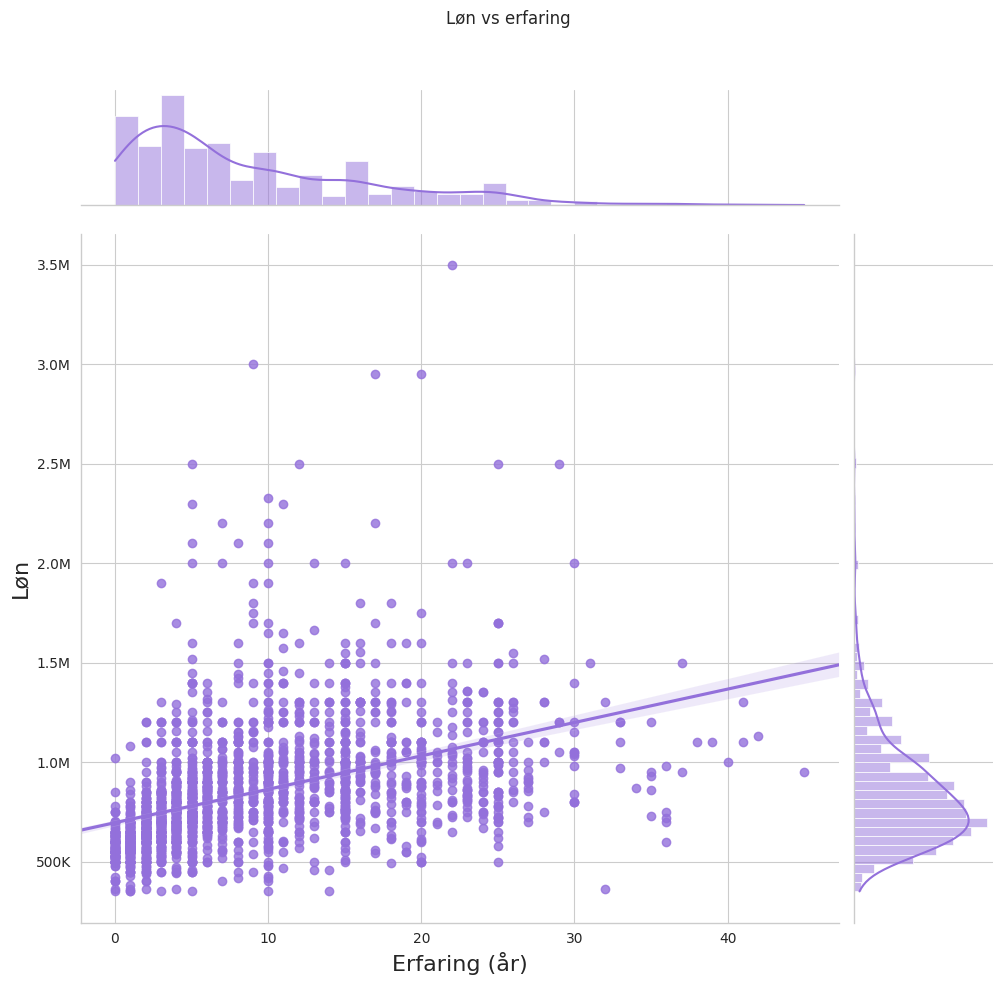

In [11]:
def currency_format(x, pos):
    'The two args are the value and tick position'
    if x >= 1e6:
        s = '{:.1f}M'.format(x*1e-6)
    else:
        s = '{:.0f}K'.format(x*1e-3)
    return s

sns.set_style('whitegrid')
g = sns.jointplot(
    x='erfaring',
    y='lønn',
    data=dataset,
    kind='reg',
    truncate=False,
    color='#9370DB',
    height=10,
)
g.set_axis_labels('Erfaring (år)', 'Løn', fontsize=16)
g.fig.suptitle('Løn vs erfaring')
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

g.ax_joint.yaxis.set_major_formatter(mtick.FuncFormatter(currency_format))

In [12]:
cleaned_data = dataset.dropna(subset=['utdanning', 'lønn'])
cleaned_data['lønn'] = cleaned_data['lønn'].astype(float)
avg_salary_by_edu = cleaned_data.groupby('utdanning')['lønn'].mean().reset_index()
lowest_point = avg_salary_by_edu.loc[avg_salary_by_edu['lønn'].idxmin()]
highest_point = avg_salary_by_edu.loc[avg_salary_by_edu['lønn'].idxmax()]

fig = px.line(
    avg_salary_by_edu,
    x='utdanning',
    y='lønn',
    labels={'utdanning': 'Utdanning', 'lønn': 'Gjennomsnittslønn (NOK)'}
)


fig.add_trace(
    go.Scatter(
        x=[lowest_point['utdanning']],
        y=[lowest_point['lønn']],
        mode='markers+text',
        marker=dict(color='red', size=10),
        name='Lågast løn',
        text=[f'Lågast løn: {lowest_point["lønn"]:,.0f} NOK, Utdanning: {int(lowest_point["utdanning"])} år'],
        textfont=dict(size=10, color='red'),
        textposition='bottom right'
    )
)
fig.add_trace(
    go.Scatter(
        x=[highest_point['utdanning']],
        y=[highest_point['lønn']],
        mode='markers+text',
        marker=dict(color='green', size=10),
        name='Høgest løn',
        text=[f'Høgast løn: {highest_point["lønn"]:,.0f} NOK, Utdanning: {int(highest_point["utdanning"])} år'],
        textfont=dict(size=10, color='green'),
        textposition='top left'
    )
)

fig.update_layout(
    xaxis_title='Utdanning',
    yaxis_title='Gjennomsnittsløn (NOK)',
    width=800,
    height=400,
    font=dict(size=10)
)

fig.update_layout(showlegend=False)
fig.show()

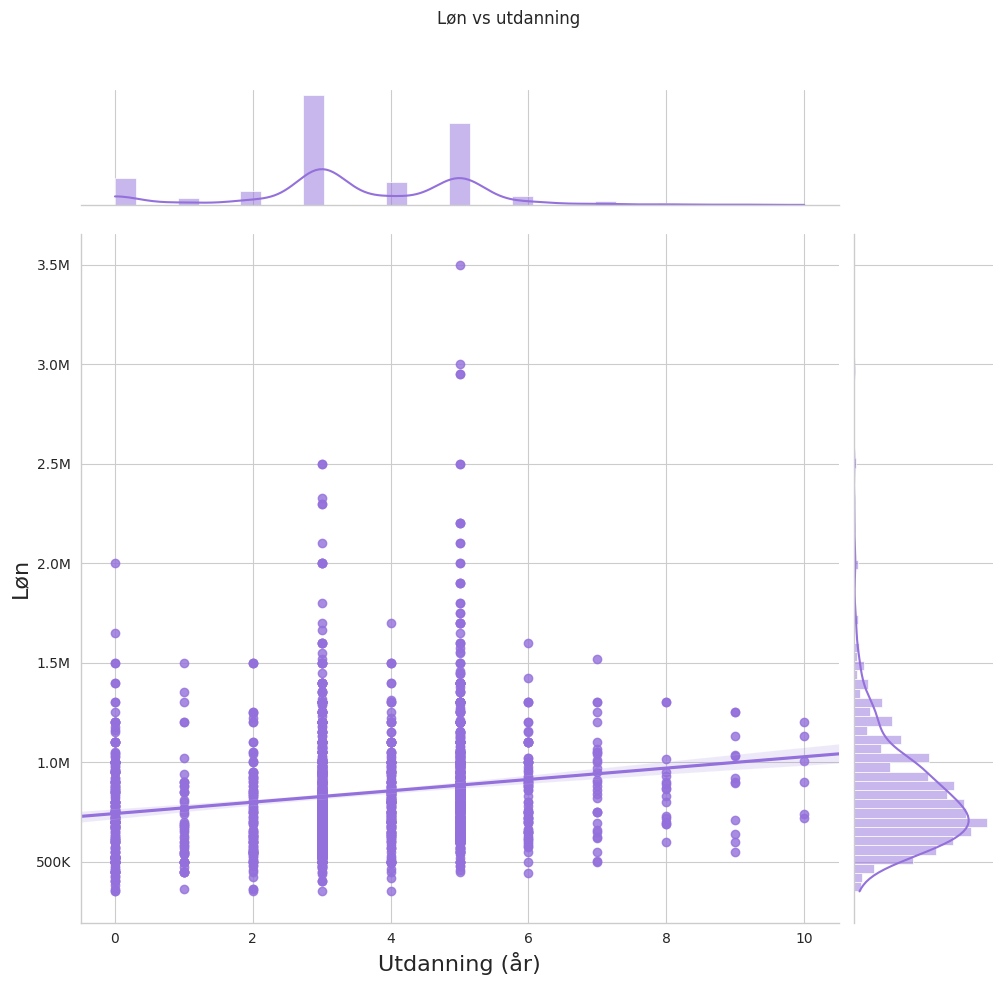

In [13]:
sns.set_style('whitegrid')
g = sns.jointplot(
    x='utdanning',
    y='lønn',
    data=dataset,
    kind='reg',
    truncate=False,
    color='#9370DB',
    height=10
)
g.set_axis_labels('Utdanning (år)', 'Løn', fontsize=16)
g.fig.suptitle('Løn vs utdanning')
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)

g.ax_joint.yaxis.set_major_formatter(mtick.FuncFormatter(currency_format))

# Privat, offentleg, konsulent, eller frilans

In [14]:
avg_salaries_by_employer = dataset.groupby('jobb')['lønn'].mean().reset_index().sort_values(by='lønn', ascending=True)

fig = px.bar(
    avg_salaries_by_employer,
    y='jobb', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'jobb': 'Jobb', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Jobb',
    width=800,
    height=400,
    font=dict(size=10)    
)

for i, row in avg_salaries_by_employer.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['jobb'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()

In [15]:
avg_salaries_by_employer = dataset.groupby('jobb')['lønn'].mean().reset_index()
sorted_city = avg_salaries_by_employer.sort_values(by='lønn', ascending=True)['jobb']
dataset_sorted = dataset.set_index('jobb').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='jobb',    
    width=800, 
    height=400, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Jobb',  
    font=dict(size=10)    
)

fig.show()

# Korrelasjon mellom lønn og andre variablar

In [16]:
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].astype('category')
        dataset[col] = dataset[col].cat.codes

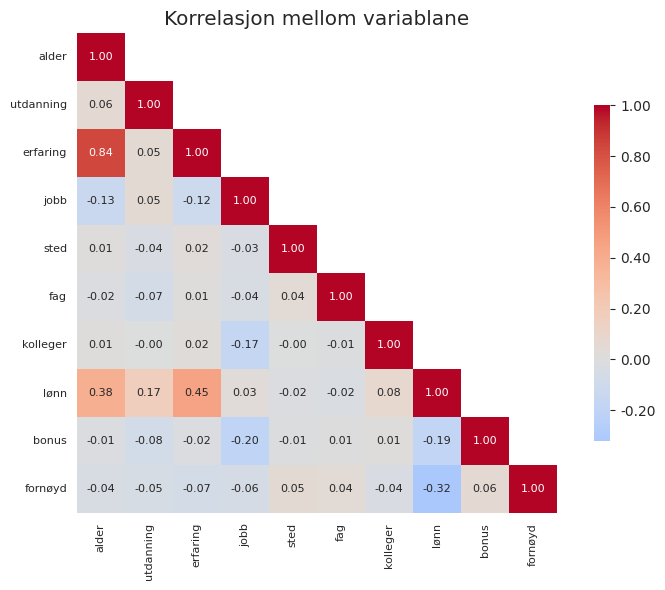

In [17]:
corr_train = dataset.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax
)
ax.set_title('Korrelasjon mellom variablane')
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

# Prediksjon av løn

In [18]:
dataset = pd.read_csv('/kaggle/input/lonn-data/kode24s_lonnstall_2023.csv')

In [19]:
dataset

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
0,21-25,2.0,5.0,"in-house, privat sektor",Oslo,sikkerhet,100 - 500,350000.0,Ja,Ja
1,26-30,0.0,1.0,"in-house, privat sektor",Innlandet,fullstack,100 - 500,350000.0,Nei,Nei
2,31-35,3.0,14.0,"in-house, privat sektor",Viken,ingen av disse,100 - 500,350000.0,Nei,Nei
3,26-30,NaN,3.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,350000.0,Ja,Nei
4,31-35,4.0,0.0,"in-house, privat sektor",Viken,fullstack,under 10,350000.0,Nei,Nei
...,...,...,...,...,...,...,...,...,...,...
2336,21-25,0.0,0.0,"in-house, privat sektor",Viken,frontend,under 10,NaN,Ja,Nei
2337,21-25,0.0,4.0,"in-house, privat sektor",Vestfold og Telemark,fullstack,under 10,NaN,Nei,Nei
2338,26-30,5.0,5.0,"in-house, privat sektor",Trøndelag,frontend,under 10,NaN,Nei,Nei
2339,36-40,0.0,20.0,konsulent,Oslo,frontend,under 10,NaN,Nei,Nei


## Handsaming av NaN verdiar

In [20]:
dataset.isna().sum()

alder         1
utdanning    76
erfaring      3
jobb          0
sted          0
fag           0
kolleger      0
lønn         35
bonus         0
fornøyd       0
dtype: int64

In [21]:
dataset = dataset.dropna(subset=['lønn', 'alder'])
dataset['utdanning'] = dataset['utdanning'].fillna(dataset['utdanning'].mode()[0])
dataset['erfaring'] = dataset['erfaring'].fillna(dataset['erfaring'].mode()[0])  

In [22]:
dataset.isna().sum()

alder        0
utdanning    0
erfaring     0
jobb         0
sted         0
fag          0
kolleger     0
lønn         0
bonus        0
fornøyd      0
dtype: int64

## Konvertering av kategoriske verdiar til numeriske verdiar

In [23]:
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].astype('category')
        dataset[col] = dataset[col].cat.codes

In [24]:
dataset

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
0,1,2.0,5.0,2,4,14,2,350000.0,0,0
1,2,0.0,1.0,2,1,10,2,350000.0,1,1
2,3,3.0,14.0,2,10,11,2,350000.0,1,1
3,2,3.0,3.0,0,4,9,6,350000.0,0,1
4,3,4.0,0.0,2,10,10,6,350000.0,1,1
...,...,...,...,...,...,...,...,...,...,...
2301,6,3.0,25.0,0,10,2,6,2500000.0,1,0
2302,5,5.0,17.0,2,4,8,0,2950000.0,0,0
2303,5,5.0,20.0,0,4,4,6,2950000.0,1,0
2304,3,5.0,9.0,0,5,10,5,3000000.0,1,0


In [25]:
scaler = StandardScaler()
dataset[['erfaring', 'fag']] = scaler.fit_transform(dataset[['erfaring', 'fag']])
dataset = pd.get_dummies(data=dataset, columns=['jobb', 'bonus', 'fornøyd'],prefix=['jobb', 'bonus', 'fornoyd'])

In [26]:
dataset

,alder,utdanning,erfaring,sted,fag,kolleger,lønn,jobb_0,jobb_1,jobb_2,jobb_3,bonus_0,bonus_1,fornoyd_0,fornoyd_1
0,1,2.0,-0.488308,4,1.685153,2,350000.0,False,False,True,False,True,False,True,False
1,2,0.0,-0.999098,1,0.561474,2,350000.0,False,False,True,False,False,True,False,True
2,3,3.0,0.660971,10,0.842394,2,350000.0,False,False,True,False,False,True,False,True
3,2,3.0,-0.743703,4,0.280554,6,350000.0,True,False,False,False,True,False,False,True
4,3,4.0,-1.126795,10,0.561474,6,350000.0,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,6,3.0,2.065644,10,-1.685883,6,2500000.0,True,False,False,False,False,True,True,False
2302,5,5.0,1.044063,4,-0.000365,0,2950000.0,False,False,True,False,True,False,True,False
2303,5,5.0,1.427156,4,-1.124044,6,2950000.0,True,False,False,False,False,True,True,False
2304,3,5.0,0.022483,5,0.561474,5,3000000.0,True,False,False,False,False,True,True,False


In [27]:
class Trainer:
    def __init__(self, model, X, y, n_splits=5, n_repeats=3):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self):
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        
        oof_preds = np.zeros(len(self.X), dtype=float)
        scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = r2_score(y_val, y_pred)
            scores.append(score)
            
            oof_preds[val_idx] = y_pred
            
        return scores, oof_preds
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [28]:
models = [
    CatBoostRegressor(random_state=SEED, verbose=False),
    LGBMRegressor(random_state=SEED, verbose=-1),
    GradientBoostingRegressor(random_state=SEED),
    XGBRegressor(random_state=SEED, n_jobs=-1),
    HistGradientBoostingRegressor(random_state=SEED),
    ExtraTreesRegressor(random_state=SEED, n_jobs=-1),
]

X = dataset.drop(columns='lønn')
y = dataset['lønn']

In [29]:
model_scores = {}
model_preds = {}
for model in models:
    scores, preds = Trainer(model, X, y).fit()
    model_scores[model.__class__.__name__] = scores
    model_preds[model.__class__.__name__] = preds
    print(f'{model.__class__.__name__}: {np.mean(scores):.5f} ± {np.std(scores):.5f}')

CatBoostRegressor: 0.46121 ± 0.05164
LGBMRegressor: 0.45065 ± 0.06514
GradientBoostingRegressor: 0.48480 ± 0.03950
XGBRegressor: 0.37346 ± 0.07186
HistGradientBoostingRegressor: 0.45351 ± 0.06258
ExtraTreesRegressor: 0.36681 ± 0.05790


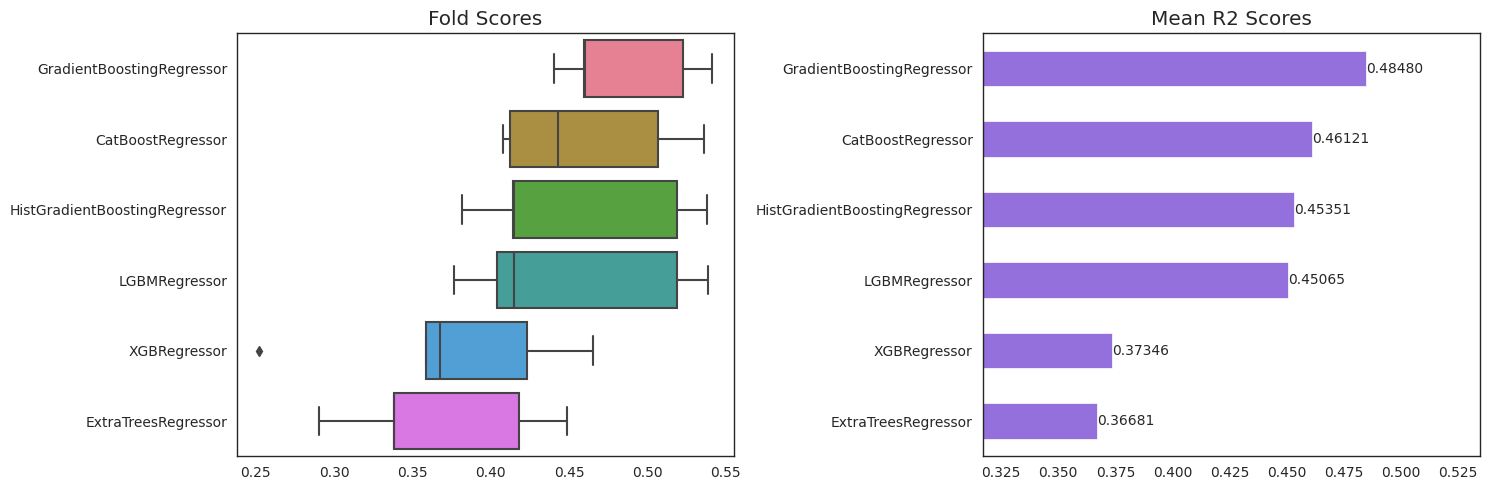

In [30]:
df = pd.DataFrame(model_scores)

sns.set_style("white") 
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, orient='h', palette='husl', ax=axes[0], order=df.mean().sort_values(ascending=False).index.tolist())
axes[0].set_title('Fold Scores')
axes[0].set_xlabel('') 
axes[0].set_ylabel('')

mean_scores = df.mean().sort_values(ascending=True)
mean_scores.plot(kind='barh', ax=axes[1], color='#9370DB')
axes[1].set_title('Mean R2 Scores')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
for j, score in enumerate(mean_scores):
    axes[1].text(score, j, f'{score:.5f}', ha='left', va='center')
axes[1].set_xlim(mean_scores.min() - 0.05, mean_scores.max() + 0.05)
    
plt.tight_layout()
plt.show()

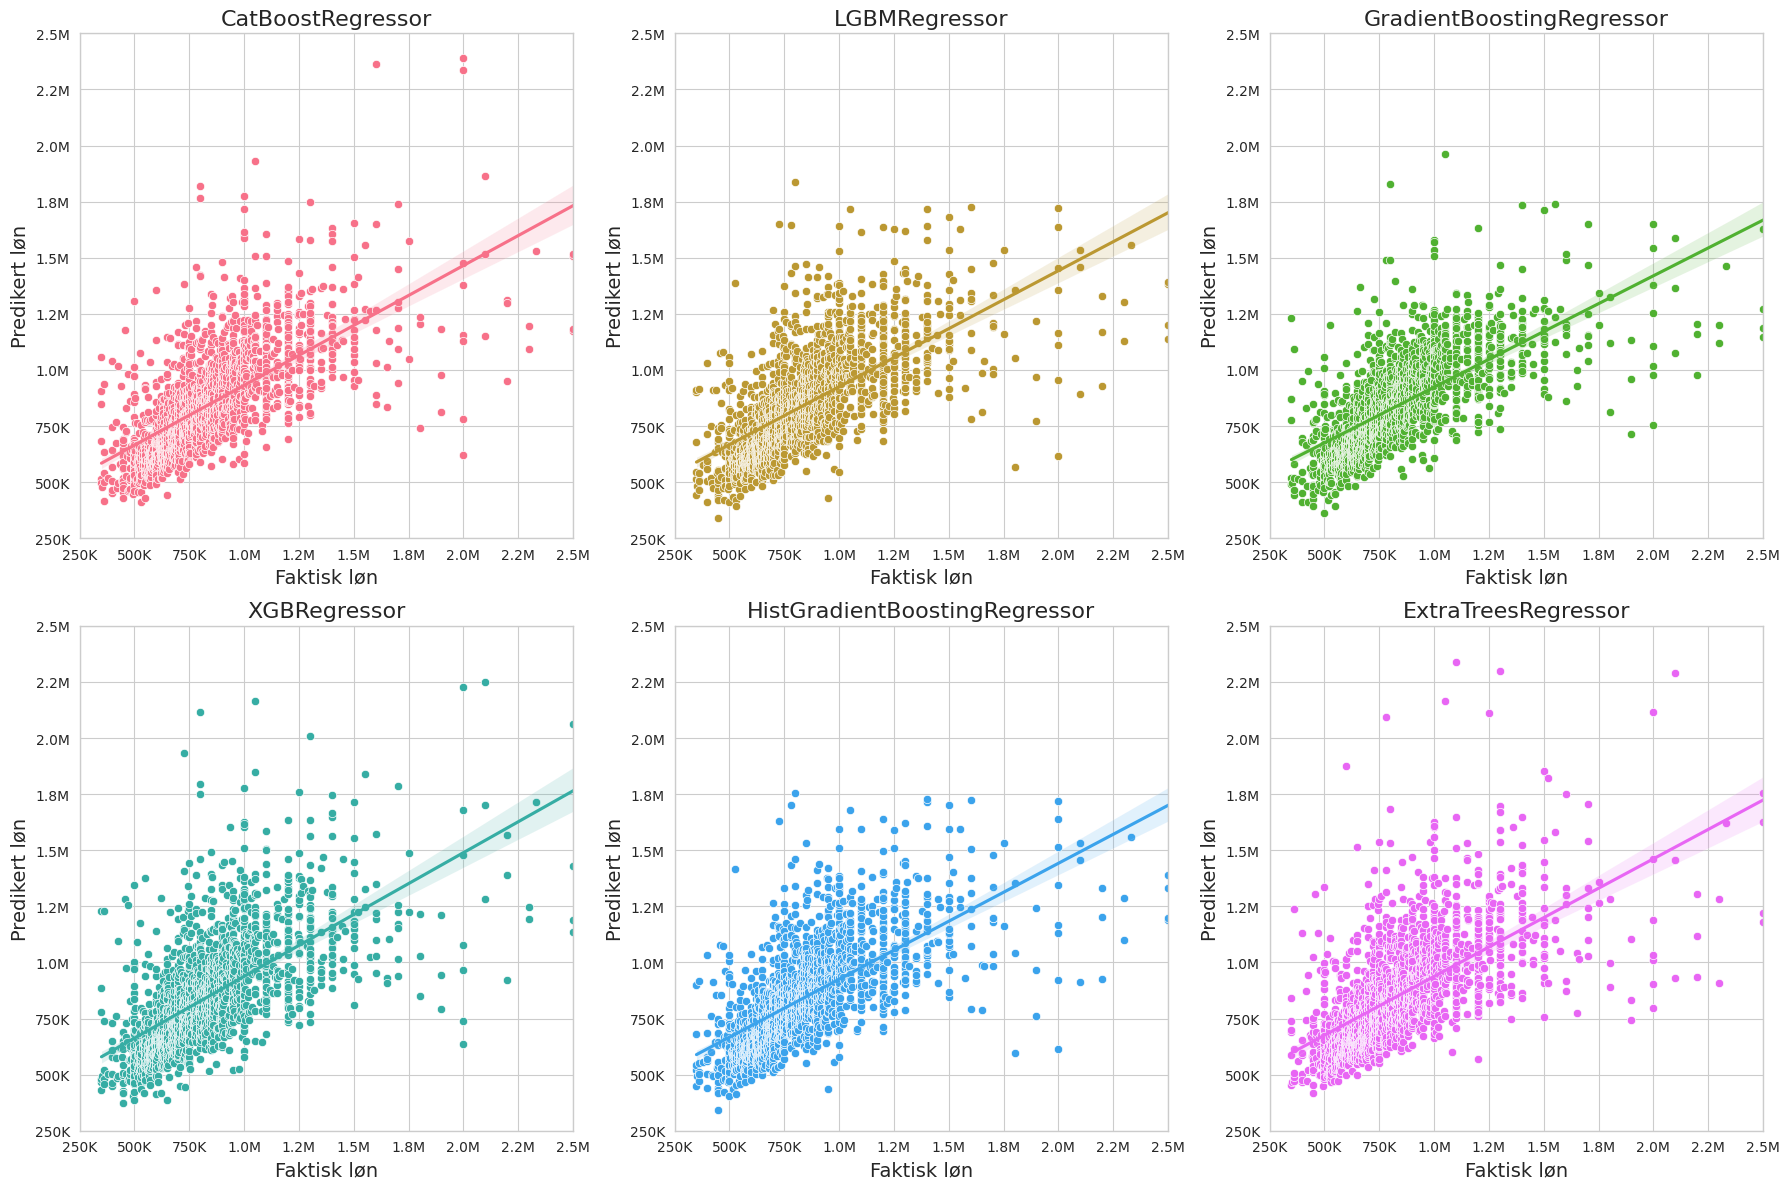

In [31]:
sns.set_style('whitegrid')

x_limit = (250_000, 2_500_000) 
y_limit = (250_000, 2_500_000) 

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (model, preds) in enumerate(model_preds.items()):
    ax = axes[i]
    ax.set_xlim(x_limit)
    ax.set_ylim(y_limit)
    
    sns.scatterplot(x=y, y=preds, ax=ax, color=sns.color_palette("husl")[i])
    sns.regplot(x=y, y=preds, ax=ax, scatter=False, color=sns.color_palette("husl")[i])
    
    ax.set_xlabel('Faktisk løn', fontsize=14)
    ax.set_ylabel('Predikert løn', fontsize=14)
    ax.set_title(model, fontsize=16)
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(currency_format))
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(currency_format))

for j in range(len(model_preds), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()